In [1]:
import json
from datetime import datetime, timedelta

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [21]:
#fname = 'bigpanda.hc_20324124.json'
#fname = 'bigpanda.hc20323822.tid1313.json'
#fname = 'bigpanda.hc20324124.tid1337.json'
#fname = 'bigpanda.hc20327391.tid1381.json'
#fname = 'bigpanda.hc20327453.tid1382.json'
fname = 'bigpanda.hc20327553.tid1381.json'
jd = json.load(open(fname))

In [3]:
jd.keys()


dict_keys(['selectionsummary', 'jobs', 'errsByCount'])

In [22]:
len(jd['jobs'])

419

In [ ]:
jd['jobs'][0]

In [23]:

df = pd.DataFrame(jd['jobs'])
len(df)

419

In [24]:
# cleanup dataset and add some further parameters
df = df[df.jobstatus=='finished'] # only finished jobs
print(len(df))

df['readfrac'] = df.totrchar*1024/df.inputfilebytes
# calculate input rate in MB/s
df['readrate'] = df.totrchar/1024/df.durationsec
df['evtrate'] = df.nevents/df.durationsec
# convert start/end time to date
df['starttime'] = pd.to_datetime(df['starttime'])
df['endtime'] = pd.to_datetime(df['endtime'])
df['cputype']=[x[2:16] for x in df.cpuconsumptionunit]
# work load run-time from pilottiming list
df['wlruntime'] = [int(x.split('|')[2]) for x in df.pilottiming]
df['wlreadrate'] = df.totrchar/1024/df.wlruntime
df['wlcpueff'] = df.cpuconsumptiontime/df.wlruntime

# only entries later than ...
#df = df[df.starttime>datetime.fromisoformat('2026-01-22 16:00:00')]

# calculate avg time of job in mins since start of test 
st0 = df.starttime.min().floor('min')
# mean time of runing job 
avt = df.starttime+(df.endtime-df.starttime)/2
dt  = [ (st-st0).total_seconds() / 60 for st in  avt]
df['avg_minute'] = dt
df['start_minute'] = [ int((st-st0).total_seconds()) / 60 for st in  df.starttime]



print(len(df))

277
277


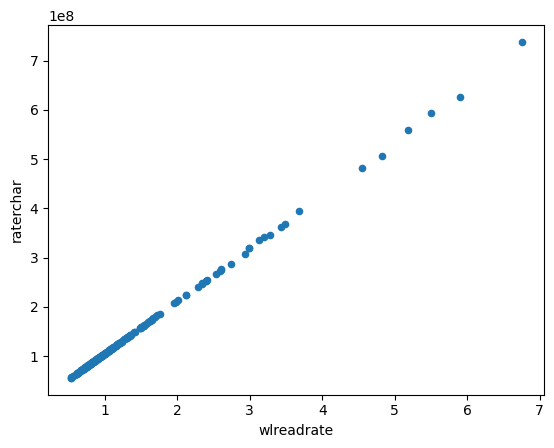

In [25]:
df.plot.scatter('wlreadrate','raterchar');

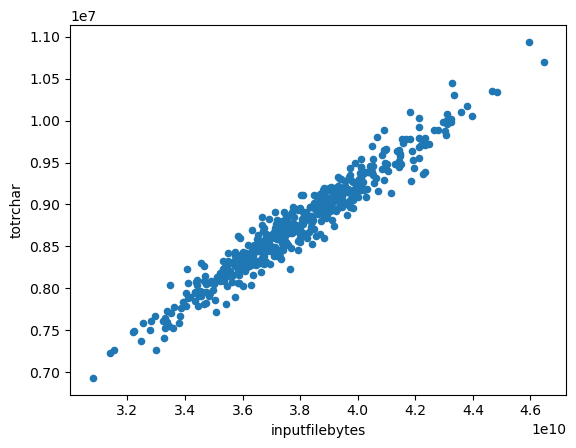

In [10]:
df.plot.scatter('inputfilebytes','totrchar');

In [26]:
print(f'total GB read {df.totrchar.sum()/1e6:.3f}\ntotal GB filesize {df.inputfilebytes.sum()/1e9:.3f}')

total GB read 2458.286
total GB filesize 10522.862


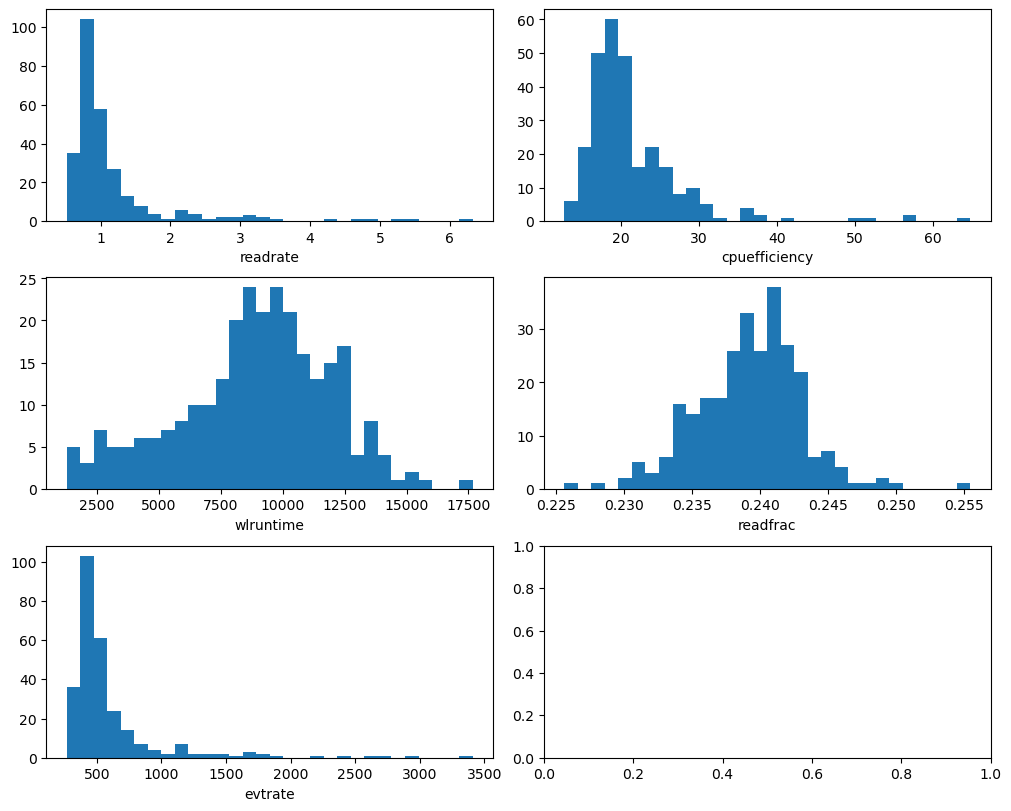

In [27]:
# some basic dists

fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(10, 8),constrained_layout=True)
pcols = ['readrate','cpuefficiency','wlruntime','readfrac','evtrate']

for x,p in zip(axes.flatten(),pcols):
    x.hist(df[p],bins=30)
    x.set_xlabel(p)



<Axes: xlabel='wlcpueff', ylabel='Count'>

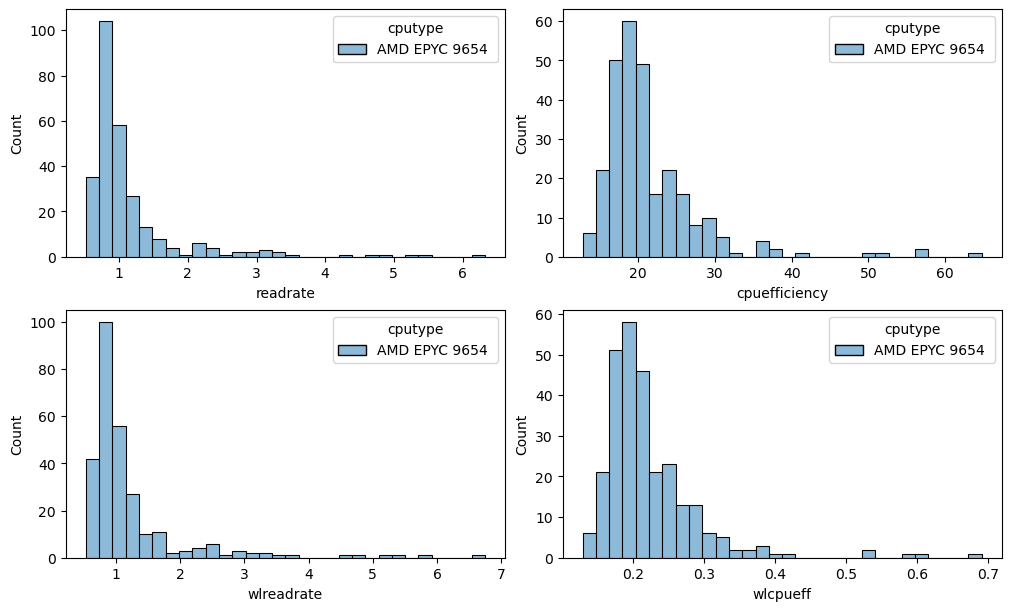

In [28]:
#df.hist('readrate',by='cputype',sharex=True)
# Create subplots
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 6), constrained_layout=True)

# Using seaborn's displot for overlayed histograms
axes = axes.flatten()
sns.histplot(data=df, ax=axes[0], x='readrate', hue='cputype', bins=30)
sns.histplot(data=df, ax=axes[1], x='cpuefficiency', hue='cputype', bins=30)
sns.histplot(data=df, ax=axes[2], x='wlreadrate', hue='cputype', bins=30)
sns.histplot(data=df, ax=axes[3], x='wlcpueff', hue='cputype', bins=30)


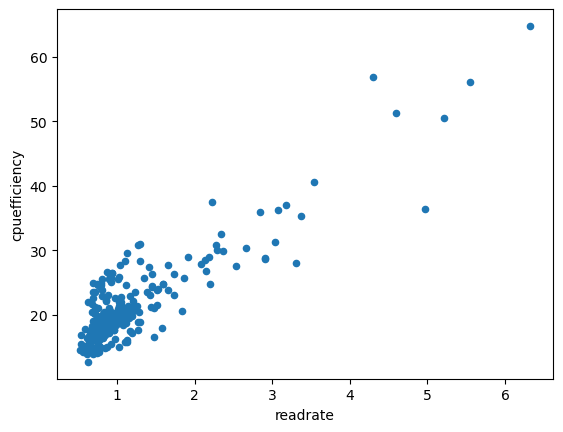

In [29]:
df.plot.scatter('readrate','cpuefficiency');

In [31]:
# timeline of jobs and IO rate

st = df.starttime.min().floor('min')
et = df.endtime.max().ceil('min')
minutes_diff = (et-st).total_seconds() / 60
st,et,minutes_diff

(Timestamp('2026-01-25 11:37:00'), Timestamp('2026-01-25 21:38:00'), 601.0)

In [32]:
# calculate sum of running jobs and sum of transfer-rate vs time

nbins = int(minutes_diff+1)
bins = np.arange(nbins+1)
counts = np.zeros(nbins)
trate = np.zeros(nbins)
ct = st
for i in range(nbins):
    counts[i] = df[(df.starttime<ct) &  (df.endtime>ct)].readrate.count()
    trate[i]  = df[(df.starttime<ct) &  (df.endtime>ct)].readrate.sum()
    ct += timedelta(minutes=1)

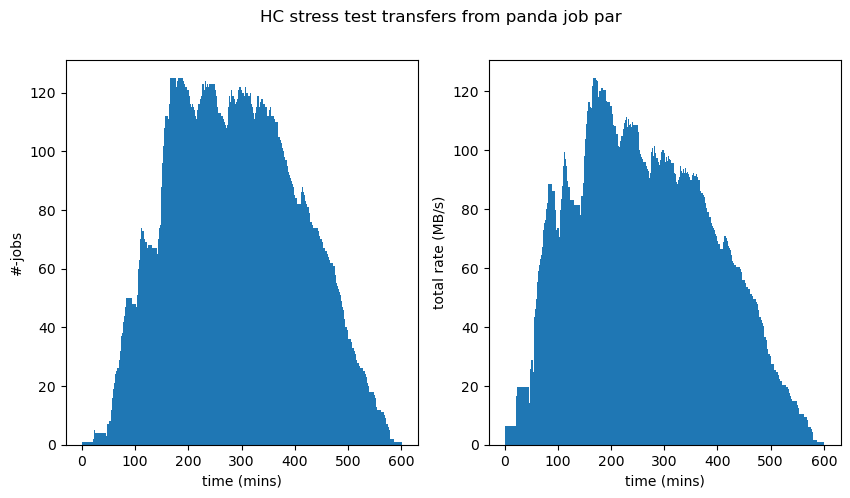

In [33]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
ax = axes[0]
ax.hist(bins[:-1],bins,weights=counts)
ax.set_xlabel('time (mins)')
ax.set_ylabel('#-jobs');

ax = axes[1]
ax.hist(bins[:-1],bins,weights=trate)
ax.set_xlabel('time (mins)')
ax.set_ylabel('total rate (MB/s)');
fig.suptitle('HC stress test transfers from panda job par');
#fig.savefig('hc_stress_es_jobpar.png')

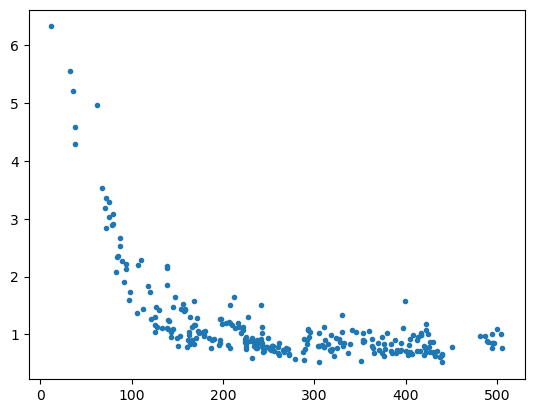

In [34]:
plt.plot(df.avg_minute, df.readrate, '.')


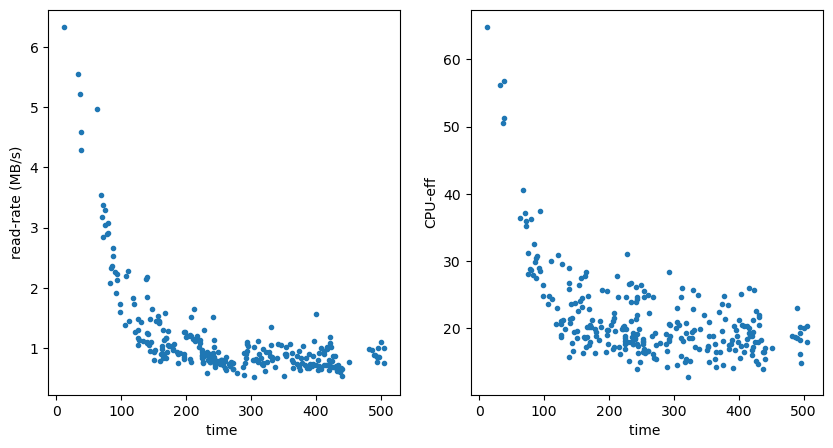

In [35]:
# plot cpu-eff & transfer rate vs time
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
ax = axes[0]
ax.plot(df.avg_minute, df.readrate,'.')
ax.set_xlabel('time ')
ax.set_ylabel('read-rate (MB/s)');

ax = axes[1]
ax.plot(df.avg_minute, df.cpuefficiency,'.')
ax.set_xlabel('time ')
ax.set_ylabel('CPU-eff');
#fig.savefig('hc_stress_es_jobpar.png')

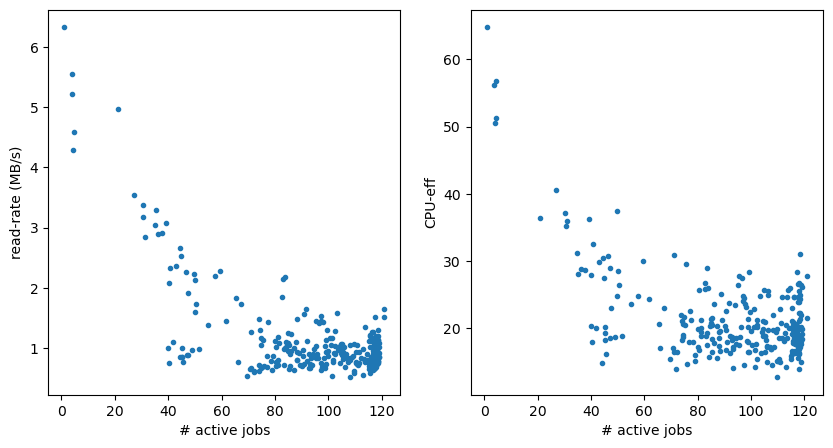

In [36]:
#njobs = [counts[int(x)] for x in df.avg_minute]

# avg number of active jobs during job execution
njobs = [sum(counts[int(s):int(s+t)])/t for s,t in zip(df.start_minute,df.durationmin)]




fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
ax = axes[0]
ax.plot(njobs, df.readrate, '.')
ax.set_xlabel('# active jobs')
ax.set_ylabel('read-rate (MB/s)');

ax = axes[1]
ax.plot(njobs, df.cpuefficiency, '.')
ax.set_xlabel('# active jobs')
ax.set_ylabel('CPU-eff');

#plt.plot(njobs, df.readrate, '.')
#plt.plot(njobs, df.cpuefficiency, '.')

